In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import os
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
root_path = 'log/'

legend_font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 12,
    }
font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }

colorlist = ['darkorange', 'cyan', 'lightsteelblue', 'plum', 'darkseagreen', 'gold', 'bisque', 'lightgreen', 'gray']
color_rgb_list = [(74/255, 135/255, 161/255), (222/255, 144/255, 123/255), (230/255, 197/255, 180/255), (88/255, 141/255, 106/255), (147/255, 196/255, 212/255), (237/255, 204/255, 134/255), (156/255, 131/255, 131/255), (116/255, 126/255, 73/255), (61/255, 71/255, 59/255), (36/255, 74/255, 96/255)]

def extract_number(feature, data, split_str):
    result_list = []
    for line in data:
        #print(line)
        seg = re.split(split_str, line)
        if set(feature).issubset(set(seg)):
            for item in seg:
                if item.lstrip('-').replace('.', '').replace(',', '').isdigit():
                    item = item.replace(',', '')
                    try:
                        result_list.append(int(item))  
                    except ValueError:
                        result_list.append(float(item))  
                        
    return result_list
                
def process_log(root_path, log_path, steps_feature = ['components'], \
                steps_split = ' |\n', val_split = ' |\n|\)|\(|%', val_features = ['set:', 'Accuracy:', 'Test']):
    with open(root_path + log_path, 'r') as f:
        data = f.readlines()
        steps_list = extract_number(feature = steps_feature, data = data, split_str = steps_split)
        val_list = extract_number(feature = val_features, data = data, split_str = val_split) 
    
    
    if abs(len(steps_list) -  len(val_list)) == 1:
        min_len = min(len(steps_list), len(val_list))
        return steps_list[:min_len], val_list[:min_len]
    else:
        return steps_list, val_list

def process_smooth(steps_list, val_list, smooth_len):
    steps = [0] * len(range(0, len(steps_list)-smooth_len+1, smooth_len))
    vals = [0] * len(steps)
    for i in range(0, len(steps_list)-smooth_len+1, smooth_len):
        steps[i // smooth_len]  = steps_list[i+np.argmin(val_list[i:i+smooth_len])]
        vals[i // smooth_len] = np.min(val_list[i:i+smooth_len])
    return steps, vals

In [2]:
def smooth(r_list,plot_list_len,smooth_len):
    plot_list = []
    for i in range(plot_list_len):
        plot_list.append(np.mean(r_list[i*smooth_len:(i+1)*smooth_len]))
    return plot_list

### N=30

In [145]:
# choice models
import json
GT_folder = '30'
with open('GT/'+GT_folder+'/seqdata_30Hotels.json', 'r') as f:
    seqdata = json.loads(f.read())
train_sequences = list(seqdata.values())
train_sequences = train_sequences[:int(0.8*len(train_sequences))]
seg_prob = np.zeros(4+1)
for l in train_sequences:
    seg_prob[-1] += len(l)
    for m in range(4):
        seg_prob[m] += l.count(m)
seg_prob = (seg_prob/seg_prob[-1])[:-1]
print(seg_prob)
mnl = [-2.410, -2.481, -2.187, -2.573]
lcmnl = [-2.411, -2.482, -2.175, -2.550]
mc = [-2.389, -2.519, -2.181, -2.619]
assort_net = [-2.376, -2.503, -2.058, -2.500]
average = [0,0,0,0]
for i in range(4):
    model = [mnl,lcmnl,mc,assort_net][i]
    for m in range(4):
        average[i] += seg_prob[m]*model[m]
average

[0.66472477 0.12335037 0.0669956  0.14492926]


[-2.427441326833908,
 -2.424092081797646,
 -2.4244341933182736,
 -2.38833212459874]

In [146]:
case_file = 'GT/30/'
UB_file = case_file+'SimulationLog'
with open(UB_file, 'r') as f:
    data = f.readlines()
    Overall_Testing = []
    Type_Testing = []
    Type_numbers = []
    for line in data:
        if 'Overall Testing LL -' in line:
            sp = line.split(',')
            for str_ in sp[1:-1]:
                Overall_Testing.append(float(str_.split(':')[-1]))
            Overall_Testing.append(float(sp[-1].split(':')[-1][:-2]))
        if 'Type Testing LL -' in line:
            sp = line.split(',')
            for str_ in sp[1:-1]:
                Type_Testing.append(float(str_.split(':')[-1]))
            Type_Testing.append(float(sp[-1].split(':')[-1][:-2]))
        if 'number of samples:' in line:
            Type_numbers.append(float(line.split(':')[-1]))

Overall_CM = ['mnl', 'mnl_feature', 'lcmnl', 'mc', 'assort_net', 'assort_net_feature']
Type_CM = ['mnl', 'lcmnl', 'mc', 'assort_net']
for i,cm in enumerate(Overall_CM):
    print(cm,Overall_Testing[i]*Type_numbers[0])
for i,cm in enumerate(Type_CM):
    LL = 0
    for m in range(4):
        LL += Type_Testing[i+m*4]*Type_numbers[m+1]
    print(cm,LL)

mnl -9464.547999999999
mnl_feature -9480.296
lcmnl -9456.674
mc -9350.375
assort_net -9275.572
assort_net_feature -9208.643
mnl -16360.891
lcmnl -16317.381999999998
mc -16455.404
assort_net -15997.240999999998


/tmp/ipykernel_514803/3353072960.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


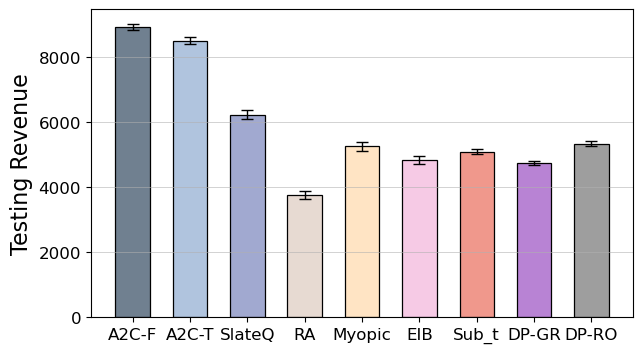

In [136]:
train_opt_here = 1

case_file = 'GT/30/'
benchmark_file = case_file+'Benchmark_INV5'
with open(benchmark_file, 'r') as f:
    data = f.readlines()
    Random_list = []
    Myopic_list = []
    EIB_list = []
    Sub_t_list = []
    DP_Greedy_list = []
    DP_Rollout_list = []
    for line in data:
        if 'mean test reward:' in line:
            Random_list.append(1000*float(line.split(',')[-6])/train_opt_here)
            Myopic_list.append(1000*float(line.split(',')[-5])/train_opt_here)
            EIB_list.append(1000*float(line.split(',')[-4])/train_opt_here)
            Sub_t_list.append(1000*float(line.split(',')[-3])/train_opt_here)
            DP_Greedy_list.append(1000*float(line.split(',')[-2])/train_opt_here)
            DP_Rollout_list.append(1000*float(line.split(',')[-1])/train_opt_here)

train_case_file = 'N=30INV=5RNNGT/'
train_stream = train_case_file+'DRLTrainLog2024-12-23-20-00-22'
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    seller_list = []
    for line in data:
        if 'mean test reward:' in line:
            seller_list.append(1000*float(line.split(',')[-7][-7:])/train_opt_here)

train_stream = train_case_file+'DRLTrainLog2025-01-02-22-34-03'
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    seller_list2 = []
    for line in data:
        if 'mean test reward:' in line:
            seller_list2.append(1000*float(line.split(',')[-7][-7:])/train_opt_here)
#DQN_seller_list = seller_list
with open(r'log/' + 'N=30INV=5DQNGT/' + 'DRLTrainLog2024-11-07-22-31-21', 'r') as f:
    data = f.readlines()
    DQN_seller_list = []
    for line in data:
        if 'mean test reward:' in line:
            DQN_seller_list.append(1000*float(line.split(',')[-1][-8:])/train_opt_here)
            
y = [np.mean(seller_list),np.mean(seller_list2),np.mean(DQN_seller_list),np.mean(Random_list),np.mean(Myopic_list),np.mean(EIB_list), np.mean(Sub_t_list), np.mean(DP_Greedy_list)
    , np.mean(DP_Rollout_list)]
#print(y)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
std_err = [np.array(seller_list).std(),np.array(seller_list2).std(),np.array(DQN_seller_list).std(),np.array(Random_list).std(),
           (np.array(Myopic_list).std()),(np.array(EIB_list).std()),(np.array(Sub_t_list).std()),
           (np.array(DP_Greedy_list).std()),(np.array(DP_Rollout_list).std())]
#print(std_err)
error_params=dict(elinewidth=1,ecolor='black',capsize=4)#设置误差标记参数

ax.bar([1,2,3,4,5,6,7,8,9],y,width=0.6,color=['slategray','lightsteelblue','#A1A9D0','#E7DAD2','bisque','#F6CAE5','#F0988C','#B883D4','#9E9E9E']#
       ,edgecolor='black',linewidth=0.9,
       yerr=std_err,error_kw=error_params,tick_label=['A2C-F','A2C-T','SlateQ','RA', 'Myopic', 'EIB', 'Sub_t','DP-GR','DP-RO'])
#ax.set_ylim(2,9)
#ax.set_yticks(range(12,19,1),size=12)
plt.ylabel('Testing Revenue',size=16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.savefig(r'plot/'+'N30'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           
plt.show();


/tmp/ipykernel_514803/3384925979.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


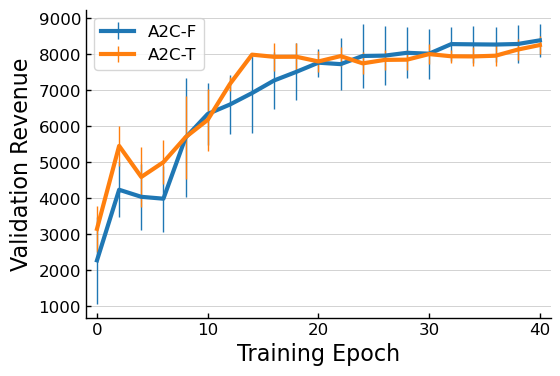

In [143]:
train_case_file = 'N=30INV=5RNNGT/'
train_stream = train_case_file+'DRLTrainLog2024-12-23-20-00-22'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    list_ = []
    result_list = []
    for line in data:
        if 'initial mean reward' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'validate reward:' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'completed' in line:
            list_.append(result_list[:41])
            result_list = []
list_ = np.array(list_[:-1]) 
y = list_.mean(0)
err = list_.std(0)
steps = np.arange(41)
x_major_locator=MultipleLocator(4)
ax.xaxis.set_major_locator(x_major_locator)
ax.errorbar(steps[::2], y[::2], yerr=err[::2],errorevery=1,elinewidth=1
             ,linewidth=3,label='A2C-F')


train_stream = train_case_file+'DRLTrainLog2025-01-02-22-34-03'
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    list_ = []
    result_list = []
    for line in data:
        if 'initial mean reward' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'validate reward:' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'completed' in line:
            list_.append(result_list[:41])
            result_list = []
list_ = np.array(list_[:-1]) 
y = list_.mean(0)
err = list_.std(0)
steps = np.arange(41)
x_major_locator=MultipleLocator(4)
ax.xaxis.set_major_locator(x_major_locator)
ax.errorbar(steps[::2], y[::2], yerr=err[::2],errorevery=1,elinewidth=1
             ,linewidth=3,label='A2C-T')


# Set labels and title
ax.set_xlabel("Training Epoch", fontsize=16)
ax.set_ylabel('Validation Revenue', fontsize=16)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)  # Set bottom spine linewidth
ax.spines['left'].set_linewidth(1)    # Set left spine linewidth

# Tick parameters
ax.tick_params(direction='in', width=1)
ax.set_xlim(-1, 41)
#ax.set_ylim(0.8, 0.95)
ax.set_xticks(steps[::10])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.legend(fontsize=12)
plt.savefig(r'plot/'+'N30_train'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           
plt.show();

### N=100

In [42]:
case_file = 'GT/100/'
UB_file = case_file+'SimulationLog'
with open(UB_file, 'r') as f:
    data = f.readlines()
    Overall_Testing = []
    Type_Testing = []
    Type_numbers = []
    for line in data:
        if 'Overall Testing LL -' in line:
            sp = line.split(',')
            for str_ in sp[1:-1]:
                Overall_Testing.append(float(str_.split(':')[-1]))
            Overall_Testing.append(float(sp[-1].split(':')[-1][:-2]))
        if 'Type Testing LL -' in line:
            sp = line.split(',')
            for str_ in sp[1:-1]:
                Type_Testing.append(float(str_.split(':')[-1]))
            Type_Testing.append(float(sp[-1].split(':')[-1][:-2]))
        if 'number of samples:' in line:
            Type_numbers.append(float(line.split(':')[-1]))

Overall_CM = ['mnl', 'mnl_feature', 'lcmnl', 'mc', 'assort_net', 'assort_net_feature']
Type_CM = ['mnl', 'lcmnl', 'mc', 'assort_net']
for i,cm in enumerate(Overall_CM):
    print(cm,Overall_Testing[i]*Type_numbers[0])
for i,cm in enumerate(Type_CM):
    LL = 0
    for m in range(4):
        LL += Type_Testing[i+m*4]*Type_numbers[m+1]
    print(cm,LL)

mnl -10121.86
mnl_feature -10271.58
lcmnl -10220.359999999999
mc -10208.54
assort_net -9188.08
assort_net_feature -8411.9
mnl -10032.053
lcmnl -10038.243000000002
mc -9880.159
assort_net -9108.61


In [148]:
# choice models
import json
GT_folder = '100'
with open('GT/'+GT_folder+'/seqdata_100Hotels.json', 'r') as f:
    seqdata = json.loads(f.read())
train_sequences = list(seqdata.values())
train_sequences = train_sequences[:int(0.8*len(train_sequences))]
seg_prob = np.zeros(4+1)
for l in train_sequences:
    seg_prob[-1] += len(l)
    for m in range(4):
        seg_prob[m] += l.count(m)
seg_prob = (seg_prob/seg_prob[-1])[:-1]
print(seg_prob)
mnl = [-2.559, -2.664, -2.224, -2.524]
lcmnl = [-2.562, -2.659, -2.215, -2.506]
mc = [-2.558, -2.655, -2.219, -2.514]
assort_net = [-2.424, -2.614, -2.309, -2.372]
average = [0,0,0,0]
for i in range(4):
    model = [mnl,lcmnl,mc,assort_net][i]
    for m in range(4):
        average[i] += seg_prob[m]*model[m]
average

[0.66191771 0.1255616  0.07064318 0.14187751]


[-2.543552790257744,
 -2.541721151572476,
 -2.5399888271458972,
 -2.432355107590447]

/tmp/ipykernel_514803/1952292737.py:64: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


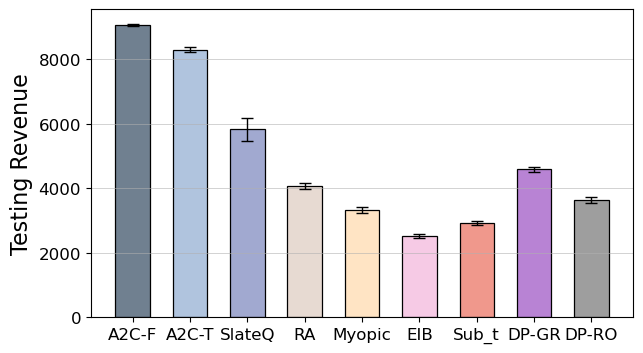

In [137]:
train_opt_here = 1

case_file = 'GT/100/'
benchmark_file = case_file+'Benchmark_INV2'

train_case_file = 'N=100INV=2RNNGT/'
train_stream = train_case_file+'DRLTrainLog2024-12-14-10-11-28'
with open(benchmark_file, 'r') as f:
    data = f.readlines()
    Random_list = []
    Myopic_list = []
    EIB_list = []
    Sub_t_list = []
    DP_Greedy_list = []
    DP_Rollout_list = []
    for line in data:
        if 'mean test reward:' in line:
            Random_list.append(1000*float(line.split(',')[-6])/train_opt_here)
            Myopic_list.append(1000*float(line.split(',')[-5])/train_opt_here)
            EIB_list.append(1000*float(line.split(',')[-4])/train_opt_here)
            Sub_t_list.append(1000*float(line.split(',')[-3])/train_opt_here)
            DP_Greedy_list.append(1000*float(line.split(',')[-2])/train_opt_here)
            DP_Rollout_list.append(1000*float(line.split(',')[-1])/train_opt_here)
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    seller_list = []
    for line in data:
        if 'mean test reward:' in line:
            seller_list.append(1000*float(line.split(',')[-7][-7:])/train_opt_here)

train_stream = train_case_file+'DRLTrainLog2025-01-02-22-34-24'
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    seller_list2 = []
    for line in data:
        if 'mean test reward:' in line:
            seller_list2.append(1000*float(line.split(',')[-7][-7:])/train_opt_here)
#DQN_seller_list = seller_list
with open(r'log/' + 'N=100INV=2DQNGT/' + 'DRLTrainLog2024-11-11-16-25-15', 'r') as f:
    data = f.readlines()
    DQN_seller_list = []
    for line in data:
        if 'mean test reward:' in line:
            DQN_seller_list.append(1000*float(line.split(',')[-1][-8:])/train_opt_here)
            
y = [np.mean(seller_list),np.mean(seller_list2),np.mean(DQN_seller_list),np.mean(Random_list),np.mean(Myopic_list),np.mean(EIB_list), np.mean(Sub_t_list), np.mean(DP_Greedy_list)
    , np.mean(DP_Rollout_list)]
#print(y)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
std_err = [np.array(seller_list).std(),np.array(seller_list2).std(),np.array(DQN_seller_list).std(),np.array(Random_list).std(),
           (np.array(Myopic_list).std()),(np.array(EIB_list).std()),(np.array(Sub_t_list).std()),
           (np.array(DP_Greedy_list).std()),(np.array(DP_Rollout_list).std())]
#print(std_err)
error_params=dict(elinewidth=1,ecolor='black',capsize=4)#设置误差标记参数

ax.bar([1,2,3,4,5,6,7,8,9],y,width=0.6,color=['slategray','lightsteelblue','#A1A9D0','#E7DAD2','bisque','#F6CAE5','#F0988C','#B883D4','#9E9E9E']#
       ,edgecolor='black',linewidth=0.9,
       yerr=std_err,error_kw=error_params,tick_label=['A2C-F','A2C-T','SlateQ','RA', 'Myopic', 'EIB', 'Sub_t','DP-GR','DP-RO'])
#ax.set_ylim(2,9)
#ax.set_yticks(range(12,19,1),size=12)
plt.ylabel('Testing Revenue',size=16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.savefig(r'plot/'+'N100'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           
plt.show();


/tmp/ipykernel_514803/3030463903.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


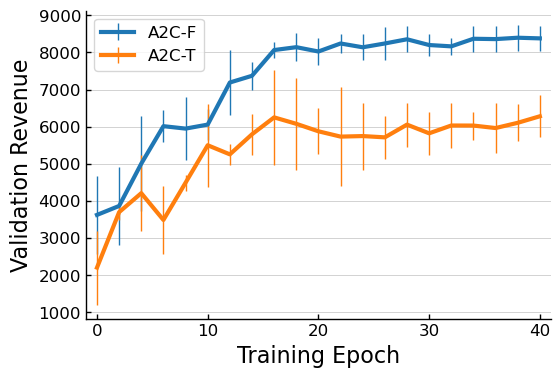

In [144]:
train_case_file = 'N=100INV=2RNNGT/'
train_stream = train_case_file+'DRLTrainLog2024-12-14-10-11-28'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    list_ = []
    result_list = []
    for line in data:
        if 'initial mean reward' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'validate reward:' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'completed' in line:
            list_.append(result_list[:41])
            result_list = []
list_ = np.array(list_[:-1]) 
y = list_.mean(0)
err = list_.std(0)
steps = np.arange(41)
x_major_locator=MultipleLocator(4)
ax.xaxis.set_major_locator(x_major_locator)
ax.errorbar(steps[::2], y[::2], yerr=err[::2],errorevery=1,elinewidth=1
             ,linewidth=3,label='A2C-F')


train_stream = train_case_file+'DRLTrainLog2025-01-02-22-34-24'
with open(r'log/' + train_stream, 'r') as f:
    data = f.readlines()
    list_ = []
    result_list = []
    for line in data:
        if 'initial mean reward' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'validate reward:' in line:
            seg = re.split(' |\n', line)[-2]
            result_list.append(1000*float(seg)/1)
        if 'completed' in line:
            list_.append(result_list[:41])
            result_list = []
list_ = np.array(list_[:-1]) 
y = list_.mean(0)
err = list_.std(0)
steps = np.arange(41)
x_major_locator=MultipleLocator(4)
ax.xaxis.set_major_locator(x_major_locator)
ax.errorbar(steps[::2], y[::2], yerr=err[::2],errorevery=1,elinewidth=1
             ,linewidth=3,label='A2C-T')


# Set labels and title
ax.set_xlabel("Training Epoch", fontsize=16)
ax.set_ylabel('Validation Revenue', fontsize=16)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)  # Set bottom spine linewidth
ax.spines['left'].set_linewidth(1)    # Set left spine linewidth

# Tick parameters
ax.tick_params(direction='in', width=1)
ax.set_xlim(-1, 41)
#ax.set_ylim(0.8, 0.95)
ax.set_xticks(steps[::10])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.legend(fontsize=12)
plt.savefig(r'plot/'+'N100_train'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           
plt.show();